In [1]:
import pickle
import time
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cur_dir = os.getcwd()
main_dir = os.path.dirname(os.path.dirname(cur_dir))

# Investigate the PZT data

In [6]:
data_dir = os.path.join(main_dir, "ConsolidatedData", "Training1_Jan2023")
filename = "consolidated_pzt_1.pkl"
# filename = "consolidated_repeated_sg_0.pkl"
# filename = "videotimed_labeled_consolidated_all.pkl"
file_path = os.path.join(data_dir, filename)
with open(os.path.join(file_path),'rb') as f:
  data = pickle.load(f)

In [7]:
data.shape

(55358000, 7)

In [12]:
pzt_data.iloc[14400000:14400000+100000]["PZT 1"]

14400000    0.000620
14400001    0.000607
14400002    0.000592
14400003    0.000621
14400004    0.000633
              ...   
14499995    0.000527
14499996    0.000496
14499997    0.000496
14499998    0.000481
14499999    0.000487
Name: PZT 1, Length: 100000, dtype: float64

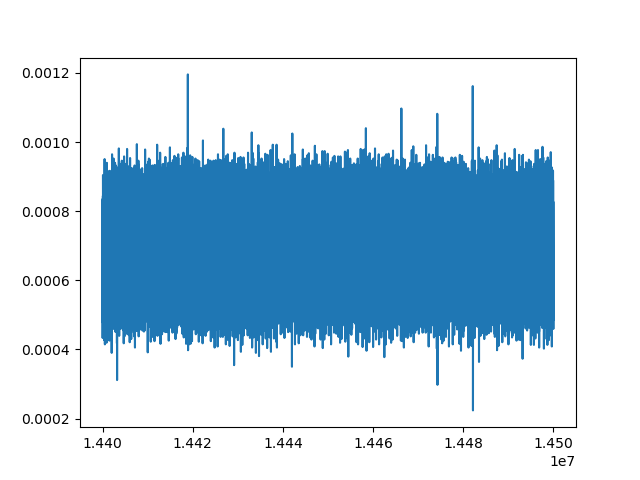

In [18]:
pzt_data = data
last_phase_pzt1 = pzt_data.iloc[14400000:14400000+100000]["PZT 1"]
plt.plot(last_phase_pzt1)

## Examine the SG/RTD Data

In [ ]:
#Experiments to shed light on the time delta between RTD&SG and PZTs
#Check for big time jumps in SG/RTD timestamps that we cannot explain.

data_dir = os.path.join(main_dir, "ConsolidatedData", "Training1")
with open(os.path.join(data_dir,'videotimed_labeled_consolidated_all.pkl'), 'rb') as f:
  training_df = pickle.load(f)
cur_dir = os.getcwd()
main_dir = os.path.dirname(os.path.dirname(cur_dir))

test_date = "08_02_2022"
test_folder = "Day2_Training1"
rtdstr_filename = "compensated_normalized_WTRUN2_day2_training1_2022-08-02_12-38-30-01_rtd-str.csv"
data_dir = os.path.join(main_dir, test_date+"_Tests", "testdata", test_folder)
file_csv = os.path.join(data_dir, rtdstr_filename)
training_df = pd.read_csv(file_csv, header=0)

rtdstr_times = training_df["Date/Time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d_%H-%M-%S-%f"))
rtdstr_times = rtdstr_times.apply(lambda x: datetime.datetime(1900, 1, 1, x.hour, x.minute, x.second, x.microsecond)) #We do this because we haven't recorded date in the original data.
training_df.insert(1, "rtdstr_DateTime Obj", rtdstr_times)


#Look at the time passed at each test run in RTD/SG data.
t1 = training_df["rtdstr_DateTime Obj"].iloc[1964089] - training_df["rtdstr_DateTime Obj"].iloc[0]
t2 = training_df["rtdstr_DateTime Obj"].iloc[-1] - training_df["rtdstr_DateTime Obj"].iloc[1964090]
time = t1+t2
time_seconds = t1.total_seconds()
print (time_seconds)

#See if there's any big time jump that we cannot quite explain.
training_df.insert(2, "Time Diff", None)
training_df['shifted_rtdstr_DateTime Obj'] = training_df['rtdstr_DateTime Obj'].shift(-1)
training_df["Time Diff"] = training_df["shifted_rtdstr_DateTime Obj"] - training_df["rtdstr_DateTime Obj"]
training_df[training_df["Time Diff"] > datetime.timedelta(0,0,100000)]

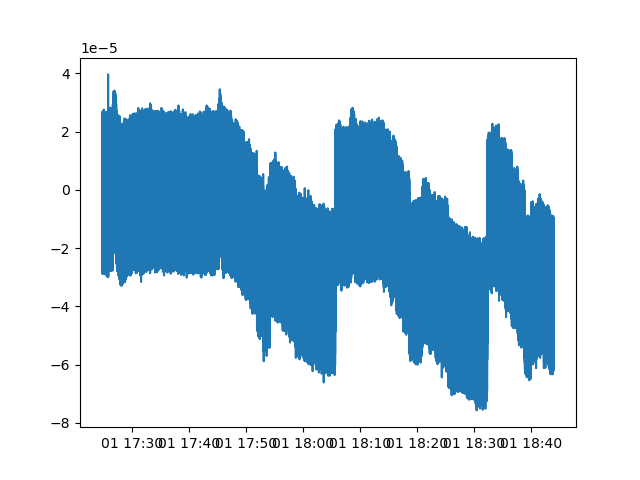

In [19]:
%matplotlib widget
data_dir = os.path.join(main_dir, "ConsolidatedData", "Training1_Jan2023")
with open(os.path.join(data_dir,'videotimed_labeled_consolidated_all.pkl'), 'rb') as f:
  df = pickle.load(f)

plt.plot(df["rtdstr_DateTime Obj"][0:600000], df["SG 1 (V) (normalized) (compensated)"][0:600000])

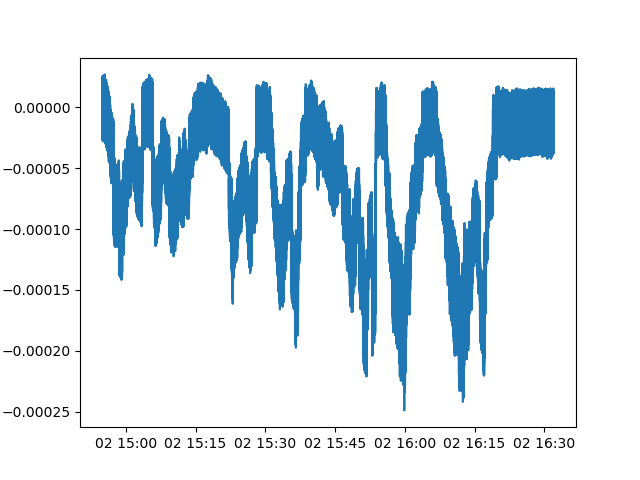

In [20]:
%matplotlib widget
data_dir = os.path.join(main_dir, "ConsolidatedData", "Dynamic1_Jan2023")
with open(os.path.join(data_dir,'videotimed_labeled_consolidated_all.pkl'), 'rb') as f:
  df = pickle.load(f)

plt.plot(df["rtdstr_DateTime Obj"], df["SG 1 (V) (normalized) (compensated)"])

# Investigate Training Data

## Investigate the concatenated data from multiple dfs

In [3]:
data_dir = os.path.join(main_dir, "KerasML", "Training1_Jan2023", "data")
multidf_data = np.load(os.path.join(data_dir, "sttr_aug2022_data_multidf.npy"))
state_labels = np.load(os.path.join(data_dir, "sttr_aug2022_statelabels.npy"))
stackedAllExamples_multidf = np.transpose(multidf_data, (1,0,2)).reshape(14, -1)

# Here data.shape = (#of states, #of sensors, #data per each state) (238, 14, 599200 for Aug. 2022 test)
# states: 7m/s_0deg, 7m/s_1deg, ... 20m/s_15deg, 20m/s_16deg.
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE']
# data: 10,000sps * ~60 seconds 


In [4]:
stackedAllExamples_multidf.shape

(14, 142609600)

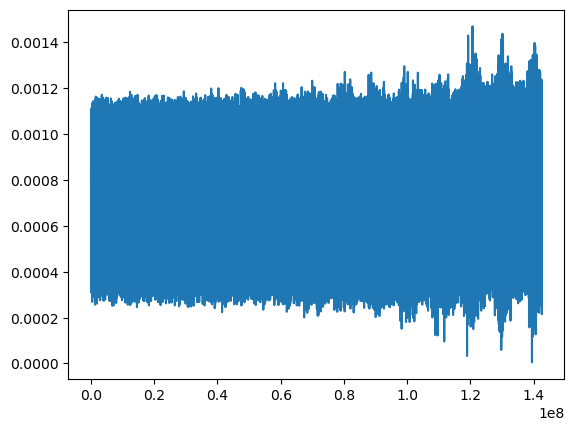

In [7]:
# Plot the SG evolution over all airspeeds and aoas
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(stackedAllExamples_multidf[7][:]) #SG 1

In [ ]:
# Plot the PZT response to observe the desync from SG/RTD.
# Best indicator is 10deg to 11deg where stall initiates
# (17m/s_10deg)(ix: 180) should happen in both
# (18m/s_10deg)(ix: 197) should happen only in singledf (because of improper concatenation)

fig, ax = plt.subplots(1)

ax.plot(stackedAllExamples_multidf[7, int(180*599200) : int(181*599200)], linewidth=0.3) #18m/s_10deg - PZT 1
ax.set_xlim(480000, 560000)
# ax.plot(stackedAllExamples_multidf[0, int(197*599200) : int(198*599200)], linewidth=0.3) #18m/s_10deg - PZT 1
# ax.set_xlim(480000, 560000)
# ax[1].plot(stackedAllExamples_multidf[7, int(197*599200) : int(198*599200)], linewidth=0.3) #18m/s_10deg - SG 1
# ax[1].set_xlim(480000, 560000)

## Plot same states from training and dynamic tests to investigate effect of changing conditions

Text(-0.05, 0.5, 'Signal (V)')

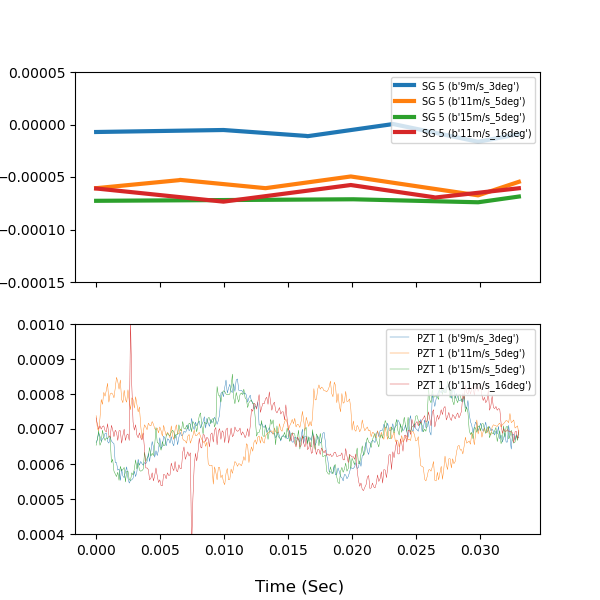

In [13]:
states=[37, 73, 141, 84]
x_axis = np.linspace(0, 0.033*1, 333*1)
fig, axs = plt.subplots(2,1, sharex=True)
for state in states:
  axs[0].plot(x_axis, multidf_data[state,10,0:333*1], linewidth=3, label="SG 5 ("+str(state_labels[state])+")")
  axs[0].legend(fontsize='x-small', loc='upper right')
  axs[0].set_ylim(-0.00015, 0.00005)
  axs[1].plot(x_axis, multidf_data[state,0,0:333*1], linewidth=0.3, label="PZT 1 ("+str(state_labels[state])+")")
  axs[1].legend(fontsize='x-small', loc='upper right')
  axs[1].set_ylim(0.0004, 0.001)

fig.set_figheight(6)
fig.set_figwidth(6)

fig.supxlabel('Time (Sec)')
fig.supylabel('Signal (V)', x=-0.05)

Text(-0.05, 0.5, 'Signal (V)')

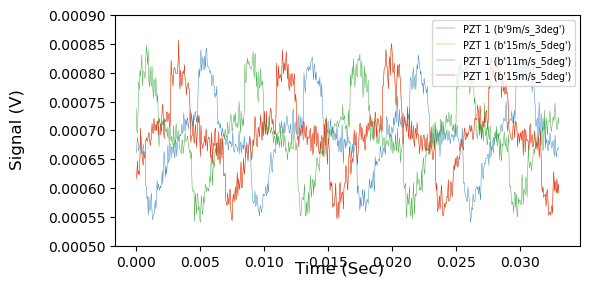

In [10]:
states=[37, 73]
x_axis = np.linspace(0, 0.033, 333*2)
fig, ax = plt.subplots(1)
for state in states:
  ax.plot(x_axis, multidf_data[state,0,0:333*2], linewidth=0.3, label="PZT 1 ("+str(state_labels[state])+")")
  ax.legend(fontsize='x-small', loc='upper right')
  ax.set_ylim(0.0005, 0.0009)
  ax.plot(x_axis, multidf_data[141,0,40:40+333*2], linewidth=0.3, label="PZT 1 ("+str(state_labels[141])+")")
  ax.legend(fontsize='x-small', loc='upper right')
  ax.set_ylim(0.0005, 0.0009)


fig.set_figheight(3)
fig.set_figwidth(6)

fig.supxlabel('Time (Sec)')
fig.supylabel('Signal (V)', x=-0.05)

In [ ]:
# Plot the PZT response to observe the desync from SG/RTD.
# Best indicator is 10deg to 11deg where stall initiates
# (17m/s_10deg)(ix: 180) should happen in both
# (18m/s_10deg)(ix: 197) should happen only in singledf (because of improper concatenation)

fig, ax = plt.subplots(1)

# ax.plot(stackedAllExamples_singledf[0, int(213*299600) : int(214*299600)], linewidth=0.3) 
# ax.set_xlim(250000, 299600)
# ax.plot(stackedAllExamples_singledf[0, int(197*599200) : int(198*599200)], linewidth=0.3) 
# ax.set_xlim(480000, 560000)
# ax[1].plot(stackedAllExamples_singledf[7, int(197*599200) : int(198*599200)], linewidth=0.3)
# ax[1].set_xlim(480000, 560000)

## Investigate the dynamic run Numpy data

In [5]:
data_dir = os.path.join(main_dir, "KerasML", "Dynamic1_Jan2023", "data")
labels_dir = os.path.join(main_dir, "KerasML", "Dynamic1_Jan2023", "labels")

run_data = np.load(os.path.join(data_dir, "dynamic1_run15.npy"))
with open (os.path.join(labels_dir, "dynamic1_run15_truth.pkl"), "rb") as file_pi:
  state_labels_dyn = pickle.load(file_pi)

In [7]:
state_labels_dyn.insert(1, "WT_Airspeed_int", round(state_labels_dyn.WT_Airspeed))
state_labels_dyn.insert(3, "WT_AoA_int", round(state_labels_dyn.WT_AoA))

ValueError: cannot insert WT_Airspeed_int, already exists

In [8]:
unique_vals = state_labels_dyn.groupby(['WT_Airspeed_int','WT_AoA_int']).size().reset_index().rename(columns={0:'count'})

In [9]:
#Print first occurrences of the columns of our interest
states_interest = [[9,3], [11,5], [15,5], [11,16]] #airspeed, AoA

for state in states_interest:
  print (state_labels_dyn[(state_labels_dyn.WT_Airspeed_int == state[0]) & (state_labels_dyn.WT_AoA_int == state[1])].first_valid_index())

2394
9843
8806
14623


Text(-0.05, 0.5, 'Signal (V)')

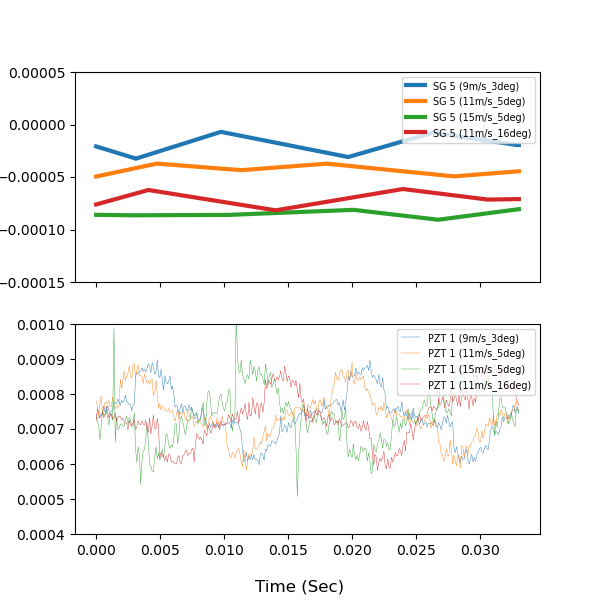

In [12]:
rows=[2394, 9843, 8806, 14623]
x_axis = np.linspace(0, 0.033*1, 333*1)
fig, axs = plt.subplots(2,1, sharex=True)

for cnt, row in enumerate(rows):
  axs[0].plot(x_axis, run_data[10,row*333:(row+1)*333], linewidth=3, label="SG 5 (" + str(states_interest[cnt][0]) + "m/s_" + str(states_interest[cnt][1]) + "deg)")
  axs[0].legend(fontsize='x-small', loc='upper right')
  axs[0].set_ylim(-0.00015, 0.00005)
  axs[1].plot(x_axis, run_data[0,row*333:(row+1)*333], linewidth=0.3, label="PZT 1 (" + str(states_interest[cnt][0]) + "m/s_" + str(states_interest[cnt][1]) + "deg)")
  axs[1].legend(fontsize='x-small', loc='upper right')
  axs[1].set_ylim(0.0004, 0.001)

fig.set_figheight(6)
fig.set_figwidth(6)

fig.supxlabel('Time (Sec)')
fig.supylabel('Signal (V)', x=-0.05)

In [14]:
# Data after ML-ready conversion

# Find out parameters
sensorCount = run_data.shape[0]
lineCount = run_data.shape[1]
windowSize = 333 #(10000/30=333) Inference in every 1/30 seconds.
splitparameter = lineCount//windowSize

# Perform transformations
examplesT = run_data.T[0:windowSize*splitparameter,:]
examples = np.reshape(examplesT, (-1,windowSize,sensorCount))

In [15]:
examples.shape

(16114, 333, 14)

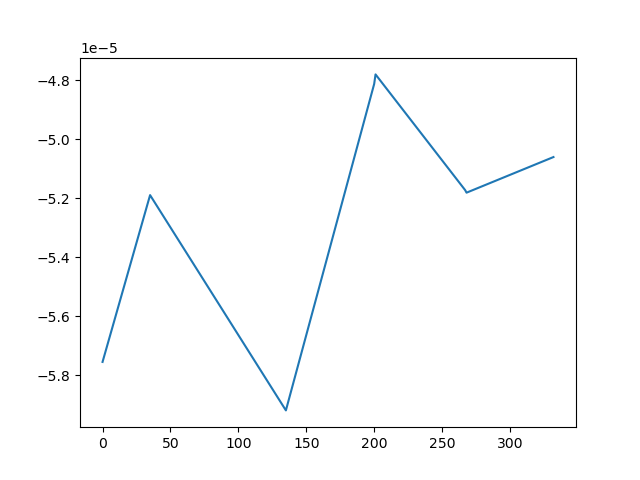

In [27]:
%matplotlib widget
plt.plot(examples[5405,:,7])

# Compare training and dynamic tests for same airspeed/AoA

In [2]:
train_data_dir = os.path.join(main_dir, "KerasML", "Training1_Jan2023", "data")
dyn_data_dir = os.path.join(main_dir, "KerasML", "Dynamic1_Jan2023", "data")
dyn_labels_dir = os.path.join(main_dir, "KerasML", "Dynamic1_Jan2023", "labels")

train_run_data = np.load(os.path.join(train_data_dir, "sttr_aug2022_data_multidf.npy"))
dyn_run_data = np.load(os.path.join(dyn_data_dir, "dynamic1_run15.npy"))

train_state_labels = np.load(os.path.join(train_data_dir, "sttr_aug2022_statelabels.npy"))
with open (os.path.join(dyn_labels_dir, "dynamic1_run15_truth.pkl"), "rb") as file_pi:
  dyn_state_labels = pickle.load(file_pi)

Training state: b'9m/s_3deg'
Dynamic state: 9m/s_3deg


Text(-0.05, 0.5, 'Signal (V)')

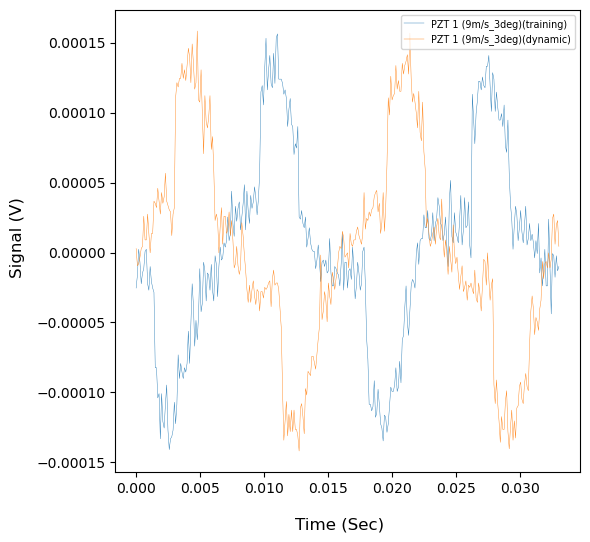

In [7]:
%matplotlib inline
# states=[37, 73, 141, 84] #All 4 states for training.
# rows=[2394, 9843, 8806, 14623] #All 4 states for dynamic
datapoints = [37, 2394]
print (f"Training state: {train_state_labels[datapoints[0]]}")

dynamic_speed = int(dyn_state_labels.loc[datapoints[1], "WT_Airspeed_int"])
dynamic_aoa = int(dyn_state_labels.loc[datapoints[1], "WT_AoA_int"])
print (f"Dynamic state: {dynamic_speed}m/s_{dynamic_aoa}deg")

x_axis = np.linspace(0, 0.033*1, 333*1)
fig, ax = plt.subplots()
ax.plot(x_axis, train_run_data[datapoints[0],0,0:333*1], linewidth=0.3, label="PZT 1 ("+str(train_state_labels[datapoints[0]])[2:-1]+")(training)")  
ax.plot(x_axis, dyn_run_data[0,datapoints[1]*333:(datapoints[1]+1)*333], linewidth=0.3, label="PZT 1 (" + str(dynamic_speed) + "m/s_" + str(dynamic_aoa) + "deg)(dynamic)")
# ax.plot(x_axis, dyn_run_data[0,datapoints[1]*333-65:(datapoints[1]+1)*333-65], linewidth=0.3, label="PZT 1 (" + str(dynamic_speed) + "m/s_" + str(dynamic_aoa) + "deg)(dynamic)(shifted)")
ax.legend(fontsize='x-small', loc='upper right')
# ax.set_ylim(0.0004, 0.001)

fig.set_figheight(6)
fig.set_figwidth(6)

fig.supxlabel('Time (Sec)')
fig.supylabel('Signal (V)', x=-0.05)

## Investigate the concatenated data from single df (backup data)

In [27]:
data_dir = os.path.join(main_dir, "KerasTraining", "Training1_B", "data")
singledf_data_backup = np.load(os.path.join(data_dir, "sttr_aug2022_data_singledf.npy"))
state_labels = np.load(os.path.join(data_dir, "sttr_aug2022_statelabels.npy"))
stackedAllExamples_singledf_frombak = np.transpose(singledf_data_backup, (1,0,2)).reshape(14, -1)

# Here data.shape = (#of states, #of sensors, #data per each state) (238, 14, 599200 for Aug. 2022 test)
# states: 7m/s_0deg, 7m/s_1deg, ... 20m/s_15deg, 20m/s_16deg.
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE']
# data: 10,000sps * ~60 seconds 

In [29]:
print (singledf_data_backup.shape)
print (stackedAllExamples_singledf_frombak.shape)

(238, 14, 299600)
(14, 71304800)


Text(0.5, 0, 'Time (sec)')

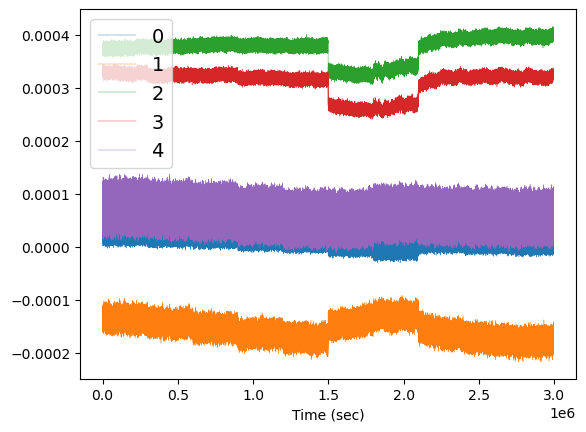

: 

In [41]:
fig, ax = plt.subplots(1)
legendkey = list()
for i in (0,1,2,3,4):
  ax.plot(stackedAllExamples_singledf_frombak[i+7,0:299600*10], linewidth=0.3)
  legendkey.append(i)
plt.legend(legendkey,loc='upper left', prop={'size':14})
plt.xlabel("Time (sec)")

# Misc. Other Investigations

In [7]:
%matplotlib widget

In [1]:
#Investigate time passed between datapoints
import datetime
# t1 = datetime.datetime(1900, 1, 1, 17, 24, 43, 50*10000) #SG/RTD data start of Day1Training1 experiment.
t1 = datetime.datetime(1900, 1, 1, 12, 38, 30, 1*10000) #SG/RTD data start of Day2Training1 experiment. 
# t1 = datetime.datetime(1900, 1, 1, 14, 32, 54, 11*10000) #SG/RTD data start of Day2Dynamic1 experiment. 
# t1 = datetime.datetime(1900, 1, 1, 17, 25, 43, 99*10000) #SG/RTD data start of Day2Training1B experiment. 
# t1 = datetime.datetime(1900, 1, 1, 17, 1, 30, 0*10000)
t2 = datetime.datetime(1900, 1, 1, 13, 5, 30, 1*10000)
# t3 = datetime.datetime(1900, 1, 1, 17, 57, 39, 82*10000)
delta = t2 - t1
print (delta)
print (delta.total_seconds())

0:27:00
1620.0
